In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import datasets, models
from torchsummary import summary
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from datetime import datetime
from pathlib import Path
from PIL import Image
from google.colab import files


For data

In [ ]:
DATA_DIR = r'../content/drive/MyDrive/coin_img'

In [ ]:
# Get filepaths and labels
image_dir = Path(DATA_DIR)
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

image_df=image_df.replace('radiate',0)
image_df=image_df.replace('laureate',1)

In [ ]:
image_df

,Filepath,Label
0,../content/drive/MyDrive/coin_img/radiate/radi...,0
1,../content/drive/MyDrive/coin_img/radiate/radi...,0
2,../content/drive/MyDrive/coin_img/radiate/radi...,0
3,../content/drive/MyDrive/coin_img/radiate/radi...,0
4,../content/drive/MyDrive/coin_img/radiate/radi...,0
...,...,...
1745,../content/drive/MyDrive/coin_img/laureate/lau...,1
1746,../content/drive/MyDrive/coin_img/laureate/lau...,1
1747,../content/drive/MyDrive/coin_img/laureate/lau...,1
1748,../content/drive/MyDrive/coin_img/laureate/lau...,1


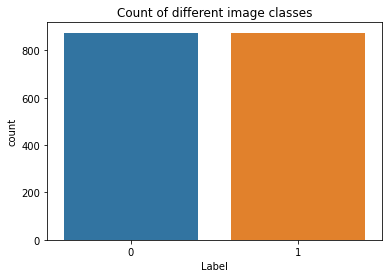

In [ ]:
sns.countplot(x='Label', data=image_df).set(title='Count of different image classes')
plt.show()

In [ ]:
#dataset for the coins
class CoinDataset(Dataset):
  def __init__(self, images, labels, transform = None):
    self.images = images
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    img = Image.open(self.images.iloc[idx])
    if self.transform:
      img = self.transform(img)
      label = torch.tensor(self.labels.iloc[idx])
    return img, label

In [ ]:
#returns each one of the data loaders for train validation and test
def get_loaders(train, train_labels, val, val_labels,test, test_labels, batch_size, train_transform, test_transform):

  train_ds = CoinDataset(images = train, labels = train_labels, transform = train_transform)
  val_ds = CoinDataset(images = val, labels = val_labels, transform = test_transform)
  test_ds = CoinDataset(images = test, labels = test_labels, transform = test_transform)

  train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle= True)
  val_loader = DataLoader(val_ds, batch_size=batch_size,shuffle= False)
  test_loader = DataLoader(test_ds, batch_size=batch_size,shuffle= False)

  return train_loader, val_loader, test_loader

Transformers

In [ ]:
#mean and std by resnet for transformers
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

In [ ]:
#resizing the images to the same size, rotating te images to range of (-10,10) degrees,and normalize 
Train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ColorJitter(brightness=.5, hue=.3),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 0.2)),
        transforms.RandomRotation(degrees = 25),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

In [ ]:
#resizing the test set
Test_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

Data split

In [ ]:
train,test, train_labels, test_labels = train_test_split(image_df.Filepath, image_df.Label, stratify = image_df.Label, test_size=0.2, shuffle=True)
train,validation, train_labels, validation_labels = train_test_split(train, train_labels, stratify = train_labels, test_size=0.2, shuffle=True)

In [ ]:
batch_size = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
train_loader, val_loader, test_loader = get_loaders(train,train_labels,validation, validation_labels, test,test_labels, batch_size,
                                                    Train_transform, Test_transform)

In [ ]:
# Define the model (resent18)
model = models.resnet18(pretrained=True)

# Freeze weights
# for param in model.parameters():
#   param.requires_grad = False

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
in_featuers = model.fc.in_features

In [ ]:
model.fc = nn.Linear(in_featuers, 2)

In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(model, (3, 256, 256))

In [ ]:
# print(model)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
epochs = 7

train_losses = np.zeros(epochs)
val_losses = np.zeros(epochs)

for it in range(epochs):
  t0 = datetime.now()
  train_loss = []
  for inputs, targets in train_loader:
      # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
    optimizer.zero_grad()

      # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
        
      # Backward and optimize
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

    # Get train loss and test loss
  train_loss = np.mean(train_loss) # a little misleading
    
  val_loss = []
  for inputs, targets in val_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    val_loss.append(loss.item())
  val_loss = np.mean(val_loss)

    # Save losses
  train_losses[it] = train_loss
  val_losses[it] = val_loss
    
  dt = datetime.now() - t0
  print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
    Validation Loss: {val_loss:.4f}, Duration: {dt}')

Epoch 1/7, Train Loss: 0.1788,     Validation Loss: 0.2584, Duration: 0:00:34.728765
Epoch 2/7, Train Loss: 0.0865,     Validation Loss: 0.1522, Duration: 0:00:33.054048
Epoch 3/7, Train Loss: 0.0787,     Validation Loss: 0.1546, Duration: 0:00:33.792208
Epoch 4/7, Train Loss: 0.0681,     Validation Loss: 0.1111, Duration: 0:00:32.857869
Epoch 5/7, Train Loss: 0.0408,     Validation Loss: 0.1107, Duration: 0:00:33.881969
Epoch 6/7, Train Loss: 0.0474,     Validation Loss: 0.1167, Duration: 0:00:33.301739
Epoch 7/7, Train Loss: 0.0414,     Validation Loss: 0.1283, Duration: 0:00:32.828642


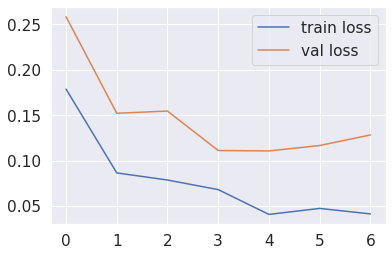

In [ ]:
# Plot the train loss and val loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()

In [18]:

# load best model
state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/crown_model_f.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [19]:
# Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9723, Test acc: 0.9800


In [20]:
nb_classes = 2
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(targets.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

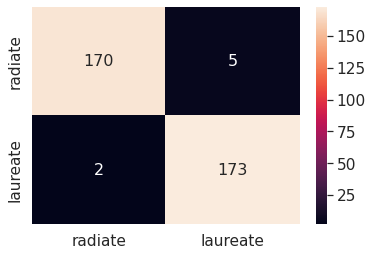

In [23]:
df_cm = pd.DataFrame(confusion_matrix, range(2), range(2))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g',xticklabels={'radiate':0,'laureate':1}, yticklabels={'radiate':0,'laureate':1})
plt.show()

In [ ]:
print(model)

In [ ]:
# Export to TorchScript
scripted_model = torch.jit.script(model)
torch.jit.save(scripted_model, "resnet18.pt")

In [ ]:
torch.save(model.state_dict(), 'crown_model_f.pth')

# download checkpoint file
files.download('crown_model_f.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>